<a href="https://colab.research.google.com/github/Lazuardis/DESinPython/blob/main/Coffee_%26_Pizza_Eatery_Chapter_3_Pseudo_Random_Number%2C_Simulation_Replication%2C_Validation_and_Input_Data_Fitting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Coffee & Pizza Eatery** 🍕🥤



Imagine you run a coffee & pizza eatery just around the corner of city main avenue. You want to observe how the eatery's daily operational take shape as you been told that, for some ocassion, the waiting time is too long, or some customer complaining why the tables are always occupied.

You then managed to gather some data from direct observation. Some data like processing time, customer interarrival time, until customer preference have been collected. And now using discrete event simulation, you try to actually understand how the eatery work, in a more quantitatively representative model.


In [ ]:
pip install simpy

In [ ]:
# import the corresponding libraries

import simpy
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns



### **Last Chapter 2 Quick Recap: Identifying Metrics and Visualizing the Result**


#### Understanding queue and utilization, and how it changes with different setting of input parameter of resource

---

Different input parameter may lead to different outcomes. This might be mostly the case if the input parameter quite sensitive in affecting the system, meaning that input parameter is crucial to the system. In the context of Discrete Event Systems (DES), resources often serve as such crucial input parameters. Resources have a direct correlation with queue length and utilization, which are commonly used as performance metrics for assessing system performance.


#### Small Adjustment to the model:
Likewise the last chapter, we made some adjustment for we found it will help the practicality and the narrative to discuss the theme of this chapter. The adjustment includes:

*   **No concept of loss opportunity of potential customer**. We find this logic will be a limiting factor for us to observe the system performance metrics. Thus, we will disregard it for now.

*   **Dismiss the need to monitor utilization**. This resulting to not recoding the `env.process() `for `monitoring_utilization` and the corresponding variables needed


### Integrating new output parameter to model: **Average Waiting Time**

As we already got output parameter of 'average number of waiting customer', the stakeholder believe that it is not enough to justify the assessment leading to operational decision. Another metric defined: 'average waiting time' then is introduced, observed to grasp how customer would experience buying coffee and pizza in the eatery.

Stakeholders hold the belief that even if the "average number of waiting customers" is low, a high "average waiting time" indicates a need for system improvement. They emphasize that a poor customer experience, even if it affects only a few customers, could be detrimental to the eatery's reputation and needs to be addressed.

Let's get goin' to the python codes!

In [ ]:
# define the neccessary data to be involved in the simulation
# NOTE: time units interpreted across the notebook are in MINUTES

inter_arrival_time = random.expovariate(1/5) #customer arriving in every 5 minutes

processing_time = {
  "till_process": random.uniform(1,3), #till process duration is uniformly distributed from a minute through 3 minutes per customer
  "coffee_process": random.gauss(2,0.5), #coffee making process duration is normally distributed averaging one minute with 0.5 min as standard deviation
  "pizza_process": random.gauss(5,1),
  "dining_in": random.gauss(15,5)
}

**Event 1: Customer Arrival**




In [ ]:
# Integrating logic of LOSS OPPORTUNITY in customer_arrival code

def customer_arrival(env, inter_arrival_time):
  global customer
  global customer_served
  global waiting_customer
  # global loss_potential_customer
  # loss_potential_customer = 0
  customer = 0 #represent the customer ID
  while True: #while the simulation is still in condition to be run
    yield env.timeout(inter_arrival_time)
    customer += 1 #customer ID added
    customer_type = random.choices([1,2,3,4], [0.4,0.3,0.2,0.1])[0]
    # print(f"customer {customer} arrives at {env.now:7.4f}")

    next_process = till_activity(env, processing_time, customer, customer_type)
    env.process(next_process) #next process is integrated within this function


**Event 2: Till Activity**





In [ ]:
def till_activity(env, processing_time, customer, customer_type):
  global waiting_customer
  waiting_time = 0 #create variable that will accumulate a customer's waiting time inside the eatery
  with staff.request() as till_request:
    till_wait_start = env.now # the customer starts waiting for till activity
    waiting_customer += customer_type
    yield till_request
    waiting_time += env.now - till_wait_start # the waiting for the customer ends as they are now serviced by a staff (staff is now available), we calculate the difference of current timestamp with the time they start waiting before
    waiting_customer -= customer_type
    yield env.timeout(processing_time["till_process"])

  order_type = random.randint(1,3)
  dining_in = random.choices([0,1], [0.2,0.8])[0]

  order_coffee = coffee_activity(env, processing_time, customer, customer_type, dining_in, waiting_time) # waiting time variable is passed to the next activity
  order_pizza = pizza_activity(env, processing_time, customer, customer_type, dining_in, waiting_time) # waiting time variable is passed to the next activity
  order_all = coffee_pizza_activity(env, processing_time, customer, customer_type, dining_in, waiting_time) # waiting time variable is passed to the next activity

  if order_type == 1:
    env.process(order_coffee)
  elif order_type == 2:
    env.process(order_pizza)
  else: env.process(order_all)

**Event 3.1: Coffee Activity**

Only proceed to this sub-event if customer order coffee only

In [ ]:
# @title

def coffee_activity(env, processing_time, customer, customer_type, dining_in, waiting_time):
  global customer_served
  global waiting_customer
  global customer_waiting_time
  with staff.request() as coffee_request:
    waiting_customer += customer_type
    order_waiting = env.now
    yield coffee_request

    yield env.timeout(processing_time["coffee_process"]*customer_type)
    waiting_customer -= customer_type
    waiting_time += env.now - order_waiting


  dining_process = dining_activity(env, processing_time, customer, customer_type, waiting_time)
  if dining_in == 1:
    env.process(dining_process) #if customer intend to dine in, proceed to dine in process
  else:
    customer_served += customer_type #customer is successfully served
    customer_waiting_time.append(waiting_customer)
    # print(f"Customer {customer} leaves at {env.now:7.4f}") #if customer intend to take away, they leave


**Event 3.2: Pizza Activity**

Only proceed to this sub-event if customer order pizza only

In [ ]:
# @title
def pizza_activity(env, processing_time, customer, customer_type, dining_in, waiting_time):
  global customer_served
  global waiting_customer
  global customer_waiting_time
  with staff.request() as pizza_request:
    waiting_customer += customer_type
    order_waiting = env.now
    yield pizza_request

    yield env.timeout(processing_time["pizza_process"]*customer_type)
    waiting_customer -= customer_type
    waiting_time += env.now - order_waiting
    # print(f"order complete at {env.now:7.4f} for customer {customer}")

  dining_process = dining_activity(env, processing_time, customer, customer_type, waiting_time)
  if dining_in == 1:
    env.process(dining_process) #if customer intend to dine in, proceed to dine in process
  else:
    customer_served += customer_type
    customer_waiting_time.append(waiting_customer)
    # print(f"Customer {customer} leaves at {env.now:7.4f}") #if customer intend to take away, they leave

**Event 3.3: Coffee & Pizza Activity**

Only proceed to this sub-event if customer order coffee & pizza

In [ ]:
# @title
def coffee_pizza_activity(env, processing_time, customer, customer_type, dining_in, waiting_time):
  global customer_served
  global waiting_customer
  global customer_waiting_time
  with staff.request() as pizza_request:
    order_waiting = env.now
    waiting_customer += customer_type
    yield pizza_request

    yield env.timeout((processing_time["pizza_process"] + processing_time["coffee_process"])*customer_type)
    waiting_time += env.now - order_waiting
    waiting_customer -= customer_type
    # print(f"order complete at {env.now:7.4f} for customer {customer}")

  dining_process = dining_activity(env, processing_time, customer, customer_type, waiting_time)
  if dining_in == 1:
    env.process(dining_process) #if customer intend to dine in, proceed to dine in process
  else:
    customer_served += customer_type
    customer_waiting_time.append(waiting_customer)
    # print(f"Customer {customer} leaves at {env.now:7.4f}") #if customer intend to take away, they leave

**Event 4: Dining Activity**





In [ ]:
# Integrate the variable that track seaters utilization in dining_activity function code

def dining_activity(env, processing_time, customer, customer_type, waiting_time):
  global customer_served
  global waiting_customer
  global twoseater_util
  global fourseater_util
  global dissatisfied_customer
  global customer_waiting_time


  table_waiting = env.now
  if customer_type <= 2:
    with two_seater.request() as twoseater_request:
      willingness_to_wait = random.uniform(10,25)
      waiting_customer += customer_type
      decision = yield twoseater_request | env.timeout(willingness_to_wait) # the decision is whether there is available two seater or not
      waiting_time += env.now - table_waiting
      if twoseater_request in decision:
        twoseater_util += 1
        waiting_customer -= customer_type

        yield env.timeout(processing_time["dining_in"]) # customer found two seater and dining in
        customer_served += customer_type
        twoseater_util -= 1


        # print(f"Dining in complete at {env.now:7.4f} for customer {customer}")
        # print(f"Customer {customer} leaves at {env.now:7.4f}")
      else:
        # print(f"Customer {customer} leaves at {env.now:7.4f}") # after 10 seconds check, customer found no seat available, hence take away
        customer_served += customer_type
        waiting_customer -= customer_type
        dissatisfied_customer += customer_type


  else:
    with four_seater.request() as fourseater_request:
      willingness_to_wait = random.uniform(10,25)
      waiting_customer += customer_type
      decision = yield fourseater_request | env.timeout(willingness_to_wait) # same exact scenario for group of three or four looking for four seater
      waiting_time += env.now - table_waiting
      if fourseater_request in decision:

        fourseater_util += 1
        waiting_customer -= customer_type
        yield env.timeout(processing_time["dining_in"])
        # print(f"Dining in complete at {env.now:7.4f} for customer {customer}")
        # print(f"Customer {customer} leaves at {env.now:7.4f}")
        customer_served += customer_type
        fourseater_util -= 1


      else:
        # print(f"Customer {customer} leaves at {env.now:7.4f}")
        customer_served += customer_type
        waiting_customer -= customer_type
        dissatisfied_customer += customer_type


  customer_waiting_time.append(waiting_time)

**Monitor Customer Function**

In [ ]:
def monitor_customer(env):
  global timestamp
  global waiting_customer_array
  timestamp = []
  waiting_customer_array = []
  while True:
    yield env.timeout(5)
    timestamp.append(env.now)
    waiting_customer_array.append(waiting_customer)

## **Discussion:**
### *Comprehending the difference in coding style for monitoring 'Average Number of Customer Waiting' and 'Average Customer Waiting Time'*

Based on the code we have done above, you could see that, in order to be able to monitor response variable that are 'Average Number of Customer Waiting' (we use term 'number waiting' interchangably), and 'Average Customer Waiting Time' (we use synonym 'time waiting'), we update the value of these variable across the developed code.

For example, to monitor 'number waiting' we add the response variable value by 1 upon a customer requesting specific resource (e.g., staff in till activity or table in dining activity). And after there is enough resource capacity to accomodate that customer, the response variable value of 'number waiting' is substracted by one, denoting that the customer is waiting no more.

The response variable that represent 'number waiting' is a universal one, or in programming/modelling lingo would be more convenient to be called as global variable. Meaning that this variable is known, valid, and perceived as one precise value by the system, let it be the system, entities or the resource.

However, when it comes to 'waiting time' it is different. 'Waiting time' is not a global variable as it may vary across the customer. Each customer might experience different waiting time from start entering the eatery until they finish. The variable 'waiting time' is attached isolatedly for each customer, in DES, it is called as 'attribute'.

\


#### **How the 'waiting time' logic work in the code:**

Attribute of 'waiting time' is an accumulation of a customer waiting for each activities they went through in the system. In this case, total waiting time of a customer is a accumulation of they waiting for till service, ordering process, and waiting for dining in.

Hence why, when it comes to coding it, we need to specify waiting time representing the accumulation of precedent waiting time as argument fed to the execution of next activity.

For example, we have this function:

```
dining_activity(env, processing_time, customer, customer_type, waiting_time)
```
This function take `waiting_time` that is the accumulation of customer waiting time from previous activities which are till and ordering process.



---






### **Chapter 3: Pseudo-Random Number, Simulation Replication, and Validation**

A simulation study is closely tied to the generation and use of random numbers. The inter-arrival of entities, activity durations, and the likelihood of events occurring are all modeled by generating random values from specific probability distributions provided as input.

Randomness, defined as something occurring without method, conscious decision, or control, aligns with the simulation model's emphasis on system uncertainty. However, when studying a random simulation model, relying solely on a pure random number generator can pose challenges. The dynamic and ever-changing nature of random number behavior introduces ambiguity in analyzing changes that lead to different outcomes during a simulation run. Therefore, a pseudo-random number generator is employed. Pseudo-random numbers are still random but can be controlled to generate the exact same sequence of random numbers based on a controlling parameter known as the seed.

In simulation and modeling tools, pseudo-random numbers are typically set by default. When working with Python, such as in this study, it is crucial to specify the random seed, contained in popular Python libraries like NumPy or random, before running a model. This ensures reproducibility and consistency in simulation results.


In [ ]:
random.seed(100) #random seed to preserve same random number generated

env = simpy.Environment() #create the essential simpy environment


staff = simpy.Resource(env, capacity = 2) #staff
two_seater = simpy.Resource(env, capacity = 2) #two seater for one or couple customer
four_seater = simpy.Resource(env, capacity = 1) #four seater for three or four group of customer

customer = 0 #set the initial customer id starting from 0
customer_served = 0 #number of customer served during the start of simulation is zero
waiting_customer = 0
dissatisfied_customer = 0
twoseater_util = 0
fourseater_util = 0

customer_waiting_time = []


env.process(customer_arrival(env, inter_arrival_time))
env.process(monitor_customer(env))
env.run(until=60*8)

print(f"Average number of customer waiting: {np.mean(waiting_customer_array):.2f}")
print(f"Average customer waiting time: {np.mean(customer_waiting_time):.2f}")

Average number of customer waiting: 5.18
Average customer waiting time: 12.37


**Interpreting the Result:**

The average number of customers waiting is 5.29 with an average waiting time of 11.09. However, relying on a single simulation run is inadequate due to system uncertainty.

For example, consider a scenario where the processing time, modeled with a normal distribution mean of 10, results in a quicker process due to random input values like 3, 4, and 5. This may give a misleadingly favorable performance measure.

To address this, simulations should be run in replications—multiple runs, with outcomes averaged to provide more representative and unbiased results that account for system variability.







### Simulation Replication

We now develop a code that could facilitate the simulation being run in huge replication. In this example, we'll set for 1000 replications

In [ ]:
random.seed(100)

avg_waiting_customer = []
replication = []
avg_waiting_time_customer = []

for rep in range(1,1000):
  random.seed(rep) #random seed to preserve same random number generated

  env = simpy.Environment() #create the essential simpy environment


  staff = simpy.Resource(env, capacity = 2) #staff
  two_seater = simpy.Resource(env, capacity = 2) #two seater for one or couple customer
  four_seater = simpy.Resource(env, capacity = 1) #four seater for three or four group of customer

  customer = 0 #set the initial customer id starting from 0
  customer_served = 0 #number of customer served during the start of simulation is zero
  waiting_customer = 0
  dissatisfied_customer = 0
  twoseater_util = 0
  fourseater_util = 0

  customer_waiting_time = []

  env.process(customer_arrival(env, inter_arrival_time))
  env.process(monitor_customer(env))
  # env.process(monitor_utilization(env))

  env.run(until=60*8) # run the simulation for 8 hours
  avg_waiting_customer.append(np.mean(waiting_customer_array))
  avg_waiting_time_customer.append(np.mean(customer_waiting_time))
  replication.append(rep)


**Check the independency of each simulation replication**

Before we analyze the result quantitatively, we want to do a particular test to see if the replications we have run are independent. This is essential to make sure that the simulation is independent between each replication. To do so, we can plot the replication ID and its observed simulation outcomes in a scatter plot, as below.

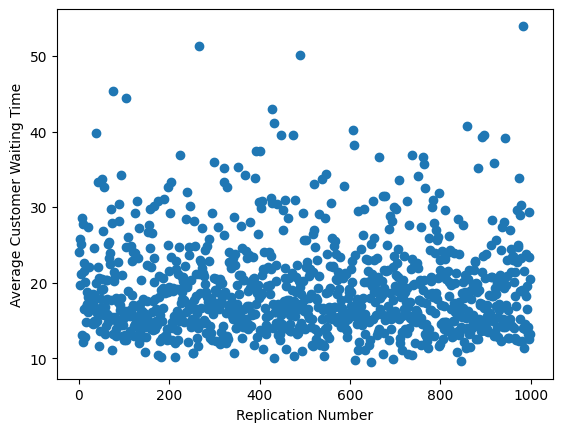

In [ ]:
plt.scatter(replication, avg_waiting_time_customer)

plt.xlabel('Replication Number')
plt.ylabel('Average Customer Waiting Time')
plt.show()



**Scatter Plot Result:**

Result from picture above shows that the scatter plot has no certain pattern at all. The way the observation points are all scattered randomly is sign of independency between replication. Therefore we are good to go to result analysis.

---



**Putting the result in Histogram**

Now we want to examine how the simulation output of 'number waiting' and 'time waiting' are shaping being put in a histogram.  

Below the graph, you could see the mean and the standard deviation

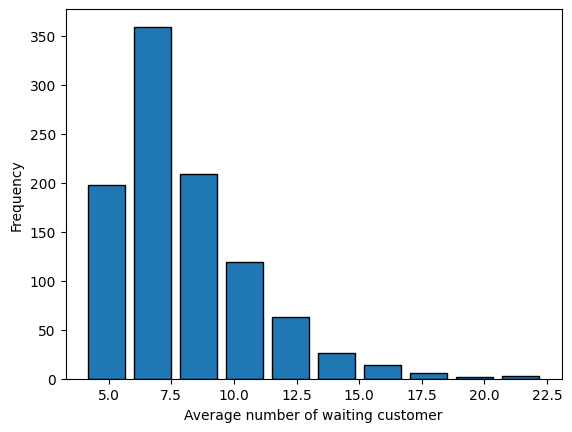

8.01
2.69


In [ ]:
plt.hist(avg_waiting_customer, rwidth=0.8, align='mid', edgecolor='black')
plt.xlabel('Average number of waiting customer')
plt.ylabel('Frequency')
plt.show()

print(f"{np.mean(avg_waiting_customer):.2f}")
print(f"{np.std(avg_waiting_customer):.2f}")

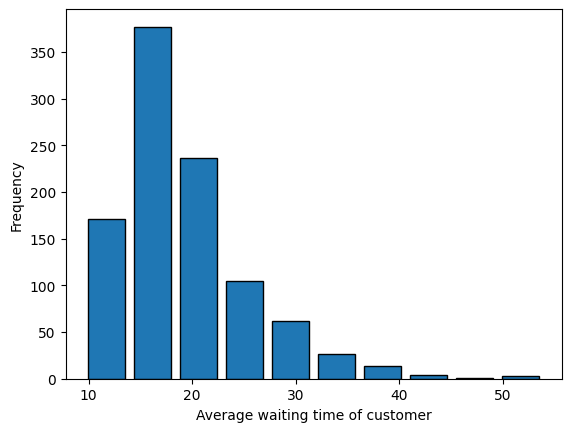

19.18
6.27


In [ ]:
plt.hist(avg_waiting_time_customer, rwidth=0.8, align='mid', edgecolor='black')
plt.xlabel('Average waiting time of customer')
plt.ylabel('Frequency')
plt.show()

print(f"{np.mean(avg_waiting_time_customer):.2f}")
print(f"{np.std(avg_waiting_time_customer):.2f}")

**Calculating the confidence interval**

The simulation results we've collected represent a collective outcome from 1000 replications. While this might seem substantial, it still only constitutes a fraction of the model's results within the virtually limitless possibilities offered by the inherent randomness. Therefore, we view the collective results from replications as a sample, not the population.

Even though we can calculate the average values of 'number waiting' and 'time waiting' across all replications, these are not the true averages of the population. Fortunately, we can derive a confidence interval. The confidence interval provides a range within which the actual population average is likely to fall, with the confidence level denoted by alpha.

Let's go calculate it




In [ ]:
import numpy as np
from scipy import stats

mean = np.mean(avg_waiting_time_customer)
std_dev = np.std(avg_waiting_time_customer, ddof=1)
alpha = 0.05

n = len(avg_waiting_time_customer)
t_score = stats.t.ppf(1 - alpha / 2, df=n - 1)
margin_of_error = t_score * (std_dev / np.sqrt(n))
confidence_interval = (mean - margin_of_error, mean + margin_of_error)
confidence_interval

(18.791268955522224, 19.570336826459037)

There you go, so we can state that 95% (alpha of 5%) we are confident that the true average of customer waiting time falls between 18.79 to 19.57.

\

#### **Is 1000 replication enough?, and how is a specific number can be considered enough?**

Determining the appropriate number of replications may be subjective. Theoretically, it is preferable to aim for a narrow confidence interval, which can be achieved by collecting results from a relatively large number of replications.

If a substantial number of replications is chosen, yet the confidence interval remains excessively wide, it suggests that the system may indeed possess a high degree of variability and uncertainties. In such cases, increasing the number of replications is advisable.

This approach is influenced by the theoretical principle of the Central Limit Theorem, which asserts that as the sample size increases, the sampling distribution of the sample mean becomes more normal, resulting in more reliable and narrower confidence intervals.

\
**Margin of Error**

Confidence interval is made by setting the sample mean minus margin of error as lower bound, and sample mean plus margin of error as upper bound. Theoretically, we want to have a small margin of error the same way as we want to have a narrow confidence interval. In numerous cases, we usually set confidence level by 95%, and margin of error by 5%

Below is how we calculate Margin of Error based on result we have got earlier.

In [ ]:
actual_moe = (confidence_interval[1] - confidence_interval[0]) / 2
actual_moe_percent = (actual_moe / mean) * 100
actual_moe_percent

2.0308531279020334

The actual margin of error is 2%, which is lower than the common target level of 5%. Thus we can state that:

"Based on the statistical test and the number of replications specified, the results indicate that you can be 95% confident that the true population average of waiting time lies within a range of ±5% of the replications mean."

###Validation

Our model has been done and run, the output has been collected. However, it is not sufficient enough to conclude that the simulation model is robust for guiding actions or scenario development. Validation is needed beforehand.

What is validation?. It is a process aimed at confirming that our simulation model accurately represents the real system. Statistical approach can be used to do validation, taking one of output/response variable computed from the simulation run and compare it with the actual variable taken from actual observation.

\

**Hypothesis Testing: t-test for comparing two samples mean**

The statistical method that can be utilized to perform validation is t-test. For this example, one sample will be the simulation output of average 'waiting time' and another sample will be the actual observation of average 'waiting time' over 100 days, represented in 100 datapoints.



In [ ]:
# Load the observation data

observed_data = pd.read_csv('observed_data.csv').to_numpy().flatten()

In [ ]:
# perform t-test hypothesis testing

from scipy.stats import ttest_ind

t_stat, p_val = stats.ttest_ind(avg_waiting_time_customer, observed_data)
p_val

0.17179654823589313

**t-test Result**:

the t-test p-value result shows 17%. This is larger than the common 5% critical value. Given this finding, we fail to reject null hypothesis, which state that there is no significant difference between two samples. This test outcomes is favorable, and we confident that the simulation model resuting in output resembling the actual system.

### **About the Observed Data**: How do we gather and process real data and use it into the simulation study?

In doing simulation study, we need to sufficiently gather data from actual system, variables that will reflect as simulation's input variable (for example, customer interarrival) and output variable (for example, average 'waiting time'). The observed input data is used to be fed to model, and observed output variable is used for validation test.

When feeding input data into the model, it's not sufficient to directly use observed data points. Doing so would merely replicate the actual model precisely. Therefore, to make the observed input data useful, we must fit it into a distribution. This approach enables us to generate a virtually limitless distribution sampling, creating input data that can be fed into the model.

In the following section, we will demonstrate how to fit a sample of observed data.

In [ ]:
# import fitter package

!pip install fitter
from fitter import Fitter, get_common_distributions, get_distributions

In this example, the observed data is assumed to have been obtained through a random sample of 500 data points from a population with a normal distribution, having a mean of 15 and a standard deviation of 2.

In [ ]:
# generate a random sampling using scipy.stats

from scipy.stats import norm

samples = norm.rvs(loc=15, scale=2, size=500)

,sumsquare_error,aic,bic,kl_div,ks_statistic,ks_pvalue
norm,0.083611,670.276510,678.705726,inf,0.024783,0.910916
lognorm,0.083612,672.280527,684.924351,inf,0.024790,0.910764
gamma,0.084609,674.267579,686.911403,inf,0.029870,0.752037
chi2,0.087191,686.497102,699.140926,inf,0.037454,0.473168
cauchy,0.159897,652.982185,661.411401,inf,0.076537,0.005403


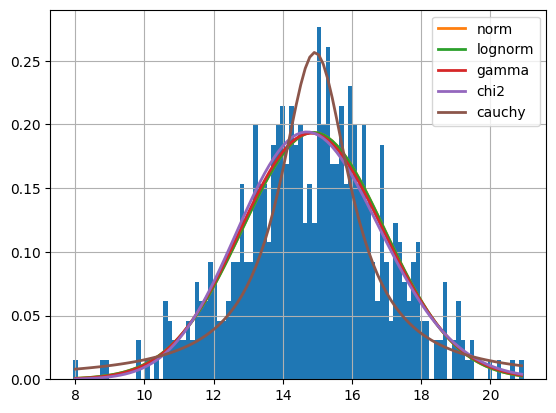

In [ ]:
# fit the data

f = Fitter(samples,
           distributions= get_common_distributions())
f.fit()
f.summary()

The results above display the five most appropriate distributions to represent the observed data. Assuming a preference for the distribution fit with the lowest sum of square error, it is evident that the normal distribution is the best fit.

To get the parameter of the distribution fit, we perform simple code below

In [ ]:
f.get_best(method = 'sumsquare_error')

{'norm': {'loc': 14.880098260991414, 'scale': 2.0595771785589445}}


The results above reveal that the observed data, after fitting, aligns best with a normal distribution having a location (mean) of 14.88 and a scale (standard deviation) of 2.06. The accuracy of this fit is confirmed, considering our prior understanding that the data was sampled from a population with a mean of 15 and a standard deviation of 2.